In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

##  Read data files

In [4]:
datasetA = []
features = None

for file in os.listdir('../../sepsis_data/trainingA/'):

    # Read file
    with open('../../sepsis_data/trainingA/%s' % (file)) as f:

        if not features:
            features = f.readline().rstrip('\n').split('|')
        else:
            # This skips the headers
            f.readline()

        for idx, line in enumerate(f):
            pid = file.split('.')[0][1:]
            line = line.rstrip('\n')
            datasetA.append([pid] + line.split('|'))

datasetA = np.array(datasetA)

In [5]:
datasetB = []
features = None

for file in os.listdir('../../sepsis_data/trainingB/'):

    # Read file
    with open('../../sepsis_data/trainingB/%s' % (file)) as f:

        if not features:
            features = f.readline().rstrip('\n').split('|')
        else:
            # This skips the headers
            f.readline()

        for idx, line in enumerate(f):
            pid = file.split('.')[0][1:]
            line = line.rstrip('\n')
            datasetB.append([pid] + line.split('|')) 

datasetB = np.array(datasetB)

In [6]:
datasetA.shape, datasetB.shape

((790215, 42), (761995, 42))

In [7]:
dfA = pd.DataFrame(datasetA, columns=['pid'] + features)

dfB = pd.DataFrame(datasetB, columns=['pid'] + features)

In [8]:
dfA = pd.concat([dfA.pid, dfA.loc[:,"HR":"SepsisLabel"].astype(np.float)], axis=1)
dfB = pd.concat([dfB.pid, dfB.loc[:,"HR":"SepsisLabel"].astype(np.float)], axis=1)

In [23]:
df = pd.concat([dfA, dfB], axis=0)

df = pd.concat([df.pid, df.loc[:,"HR":"SepsisLabel"].astype(np.float)], axis=1)

In [25]:
df.shape

(1552210, 42)

## Check if there are any differences between two datasets

In [20]:
dfA.loc[:,'EtCO2':'Platelets'].isna().sum()

EtCO2               790215
BaseExcess          707834
HCO3                726598
FiO2                678060
pH                  699600
PaCO2               720927
SaO2                751055
AST                 778395
BUN                 725739
Alkalinephos        778683
Calcium             750897
Chloride            724438
Creatinine          737728
Bilirubin_direct    789033
Glucose             693559
Lactate             763072
Magnesium           728734
Phosphate           750319
Potassium           704379
Bilirubin_total     780522
TroponinI           789250
Hct                 697157
Hgb                 720394
PTT                 751909
WBC                 730867
Fibrinogen          784185
Platelets           738716
dtype: int64

In [21]:
dfB.loc[:,'EtCO2':'Platelets'].isna().sum()

EtCO2               704359
BaseExcess          760231
HCO3                760584
FiO2                744785
pH                  745037
PaCO2               744982
SaO2                747594
AST                 748632
BUN                 719903
Alkalinephos        748586
Calcium             709982
Chloride            757306
Creatinine          719866
Bilirubin_direct    760187
Glucose             593135
Lactate             747692
Magnesium           725525
Phosphate           739590
Potassium           703306
Bilirubin_total     748547
TroponinI           748179
Hct                 717620
Hgb                 717225
PTT                 754602
WBC                 721896
Fibrinogen          757783
Platelets           721285
dtype: int64

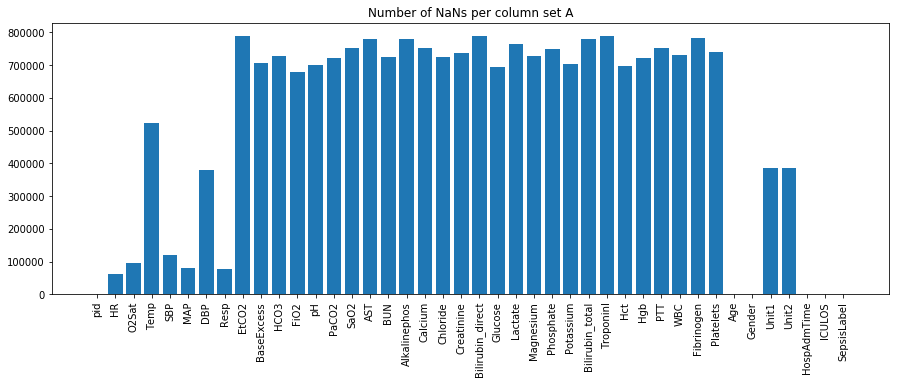

In [13]:
plt.figure(figsize=(15,5))
plt.bar(dfA.isna().sum().index, dfA.isna().sum().values)
plt.title("Number of NaNs per column set A")
plt.xticks(rotation=90)
plt.figure
plt.show()

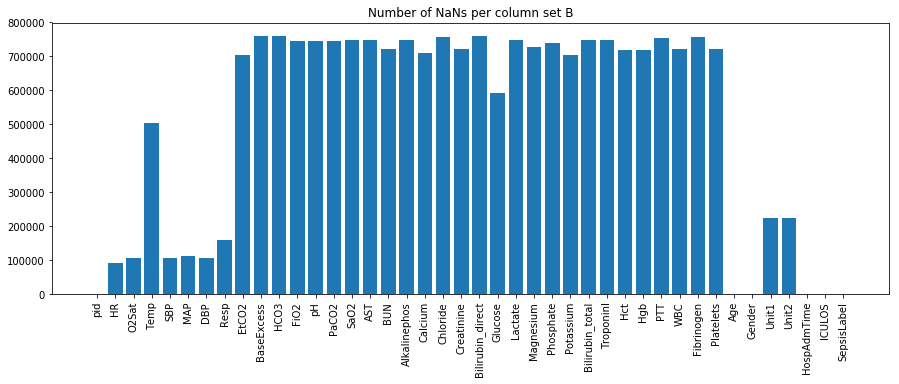

In [22]:
plt.figure(figsize=(15,5))
plt.bar(dfB.isna().sum().index, dfB.isna().sum().values)
plt.title("Number of NaNs per column set B")
plt.xticks(rotation=90)
plt.figure
plt.show()

## Exploratory Analysis

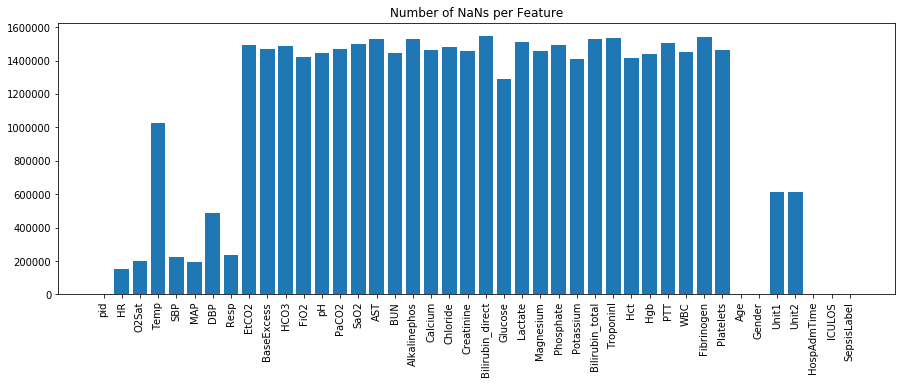

In [32]:
# Entire dataset
plt.figure(figsize=(15,5))
plt.bar(df.isna().sum().index, df.isna().sum().values)
plt.title("Number of NaNs per Feature")
plt.xticks(rotation=90)
plt.savefig("../plots/feature_missingness")
plt.show()

In [26]:
# Create violin plots
feature_data = df.loc[:, 'HR':'SepsisLabel']
feature_data.drop(columns=['Age', 'Unit1', 'Unit2', 'Gender', 'ICULOS', 'HospAdmTime'], 
                 inplace=True)

In [27]:
feature_data = (feature_data - feature_data.min())/(feature_data.max()-feature_data.min())

In [28]:
vplot_data = []
vplot_feature = []
vplot_label = []

for f in feature_data.drop(columns='SepsisLabel').columns:
    vplot_data.extend(list(feature_data[f].values))
    vplot_feature.extend([f]*feature_data[f].shape[0])
    vplot_label.extend(list(feature_data.SepsisLabel.values))

In [29]:
vplot_data = pd.Series(data=vplot_data, dtype=np.float, name="Feature Values")
vplot_feature = pd.Series(data=vplot_feature, dtype=str, name="Feature")
vplot_label = pd.Series(data=vplot_label, dtype=np.int, name="SepsisLabel")

In [30]:
vplot_df = pd.concat([vplot_data, vplot_feature, vplot_label], axis=1).dropna()

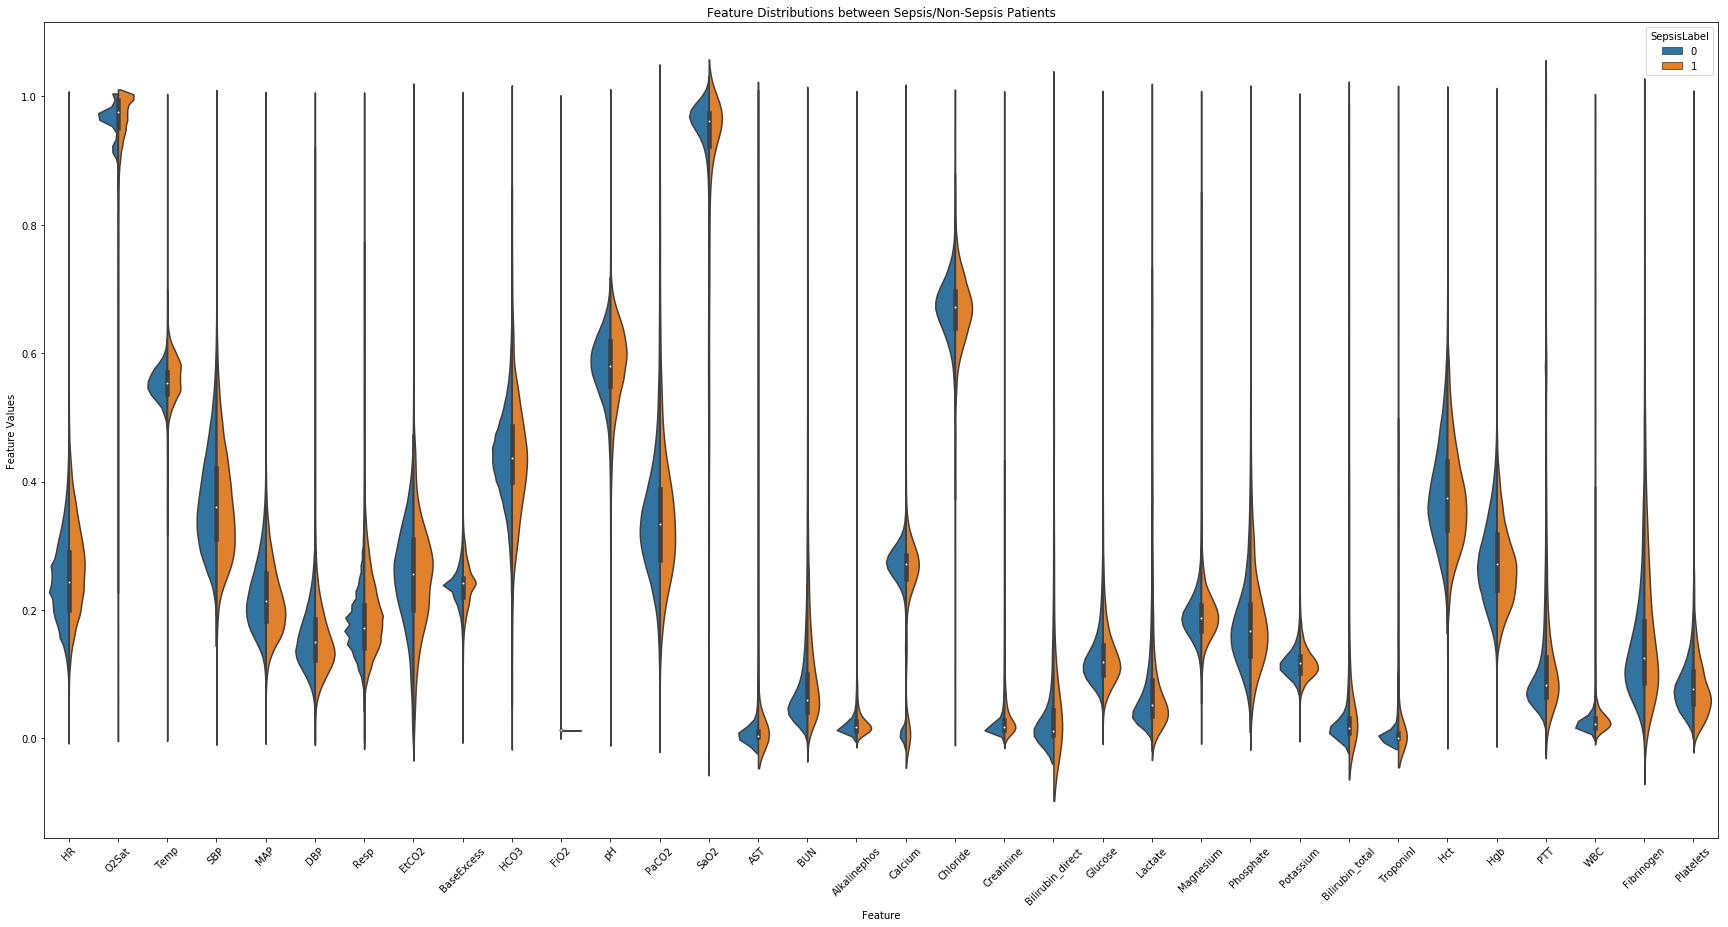

In [31]:
# Create violin plots unstratified 
plt.figure(1, figsize=(30,15))
sns.violinplot(x='Feature', y='Feature Values', data=vplot_df, hue='SepsisLabel', split=True)
plt.title("Feature Distributions between Sepsis/Non-Sepsis Patients")
plt.ylabel("Feature Values")
plt.xticks(rotation=45)
plt.savefig('../plots/feature_violin_plots')
plt.show()
plt.close()

In [36]:
# Create violin plots stratified 
for f in features[0:34]:
    f_data = dataset[[f, 'Unit1', 'Unit2', 'Gender', 'SepsisLabel']].dropna()
    f_data['Unit'] = f_data['Unit1'].replace(0, 2)
    f_data.drop(columns=['Unit1', 'Unit2'], inplace=True)
    
    plt.figure(1)
    sns.violinplot(x='Unit', y=f, data=f_data, hue='SepsisLabel', split=True)
    plt.title("%s Distribution Across ICU Units"%f)
    plt.ylabel("%s Value"%f)
    plt.savefig('../plots/%s_distr_unit'%f)
    plt.close()
    
    plt.figure(2)
    sns.violinplot(x='Gender', y=f, data=f_data, hue='SepsisLabel', split=True)
    plt.title("%s Distribution Across Gender"%f)
    plt.ylabel("%s Value"%f)
    plt.savefig('../plots/%s_distr_gender'%f)
    plt.close()
    

/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [ ]:
# Create histograms
for f in features:
    data = dataset[['pid', f, 'Unit1', 'Unit2', 'Gender', 'SepsisLabel']]
    sep_data = data.groupby('pid').filter(lambda x: x['SepsisLabel'].any() == 1)
    nonsep_data = data.groupby('pid').filter(lambda x: x['SepsisLabel'].sum() == 0)
    
    before_sep = []
    after_sep = []
    for pid, df in sep_data.groupby('pid'):
        df.reset_index(drop=True, inplace=True)
        
        first_idx = df['SepsisLabel'].idxmax()
        before_sep.extend(df.iloc[0:(first_idx+6)][[f, 'SepsisLabel']].values)
        after_sep.extend(df.iloc[(first_idx+6):][[f, 'SepsisLabel']].values)
    
    before_sep = np.array(before_sep, dtype=np.float)
    after_sep = np.array(after_sep, dtype=np.float)
    nonsep = nonsep_data[f].values
    break

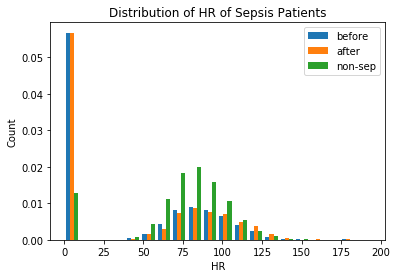

In [182]:
plt.hist([before_sep,after_sep,nonsep], bins=20, label=['before', 'after', 'non-sep'], density=True)
plt.title("Distribution of HR of Sepsis Patients")
plt.legend(loc=1, labels=['before', 'after', 'non-sep'])
plt.xlabel("%s"%f)
plt.ylabel("Count")
plt.savefig('../HR_distr')
plt.show()

### 1. Figure out number of patients with sepsis 

In [151]:
df[df.SepsisLabel == 1]['pid'].unique().shape

(1790,)

In [152]:
df[df.SepsisLabel == 1].shape

(34272, 42)

## In MIMIC-III sepsis df, half the patients have sepsis. 

### 2. Number of Septic patients between Units

In [ ]:
patient_df[]

In [ ]:
patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit1 == 1)]['pid'].unique().shape

Unit 1: 88 septic patients 

Unit 2: 191 septic patients

### Male Female Ratio

In [16]:
patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Gender == 0)]['pid'].unique().shape

(122,)

122 are female and 157 are male

In [17]:
patient_df[(patient_df.Gender == 0)]['pid'].unique().shape

(2295,)

### Age Range of Septic Patients Between ICUs

In [18]:
ages = patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit1 == 1)]['Age'].unique()

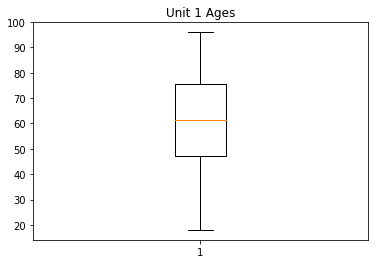

In [19]:
plt.boxplot(ages)
plt.title("Unit 1 Ages")
plt.show()

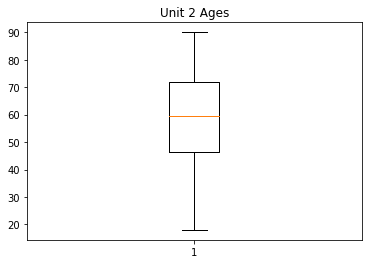

In [20]:
plt.boxplot(patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit2 == 1)]['Age'].unique())
plt.title("Unit 2 Ages")
plt.show()


## Let's look at degree of missingness

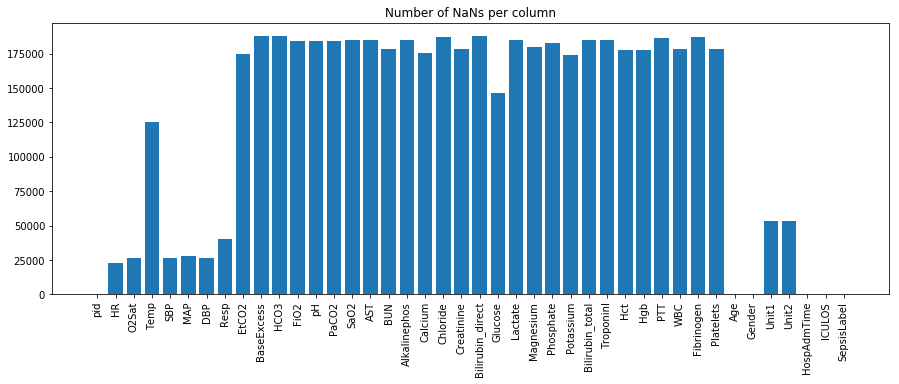

In [117]:
# Entire dataset
plt.figure(figsize=(15,5))
plt.bar(dataset.isna().sum().index, dataset.isna().sum().values)
plt.title("Number of NaNs per column")
plt.xticks(rotation=90)
plt.figure
plt.show()

In [27]:
u1_patients = patient_df[patient_df.Unit1 == 1]
u2_patients = patient_df[patient_df.Unit2 == 1]

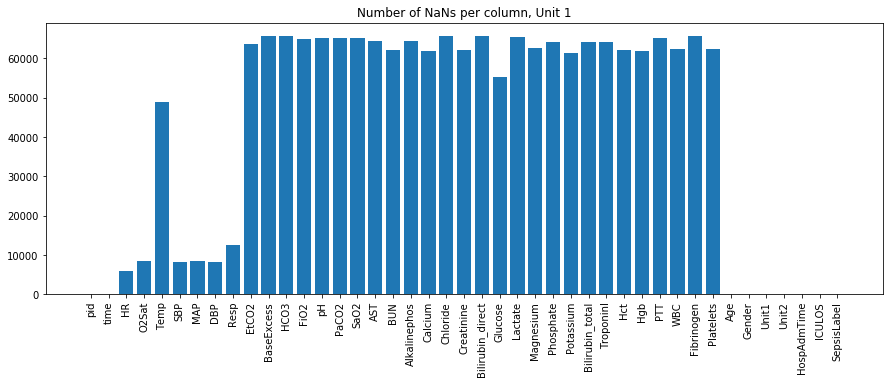

In [29]:
u1_na_count = u1_patients.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(u1_na_count.index, u1_patients.isna().sum().values)
plt.title("Number of NaNs per column, Unit 1")
plt.xticks(rotation=90)
plt.figure
plt.show()

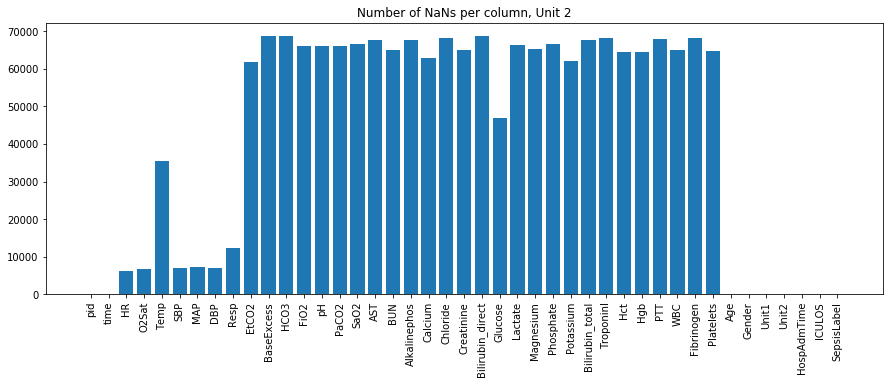

In [30]:
u2_na_count = u2_patients.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(u1_na_count.index, u2_patients.isna().sum().values)
plt.title("Number of NaNs per column, Unit 2")
plt.xticks(rotation=90)
plt.show()

### Missingness in Unit 1 is a little more than Unit 2 in 2 specific columns

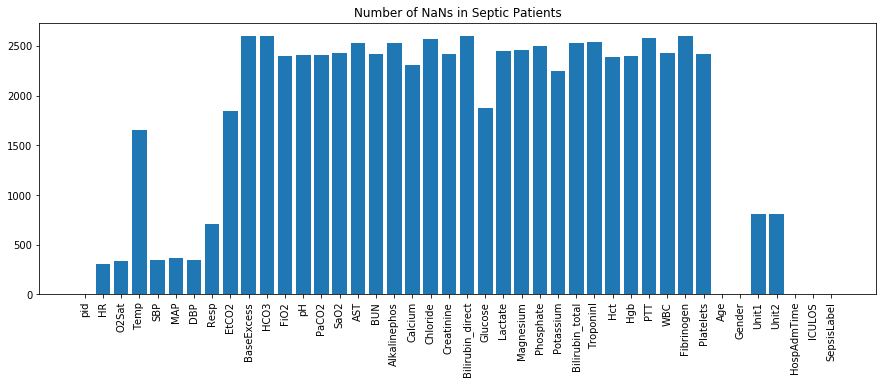

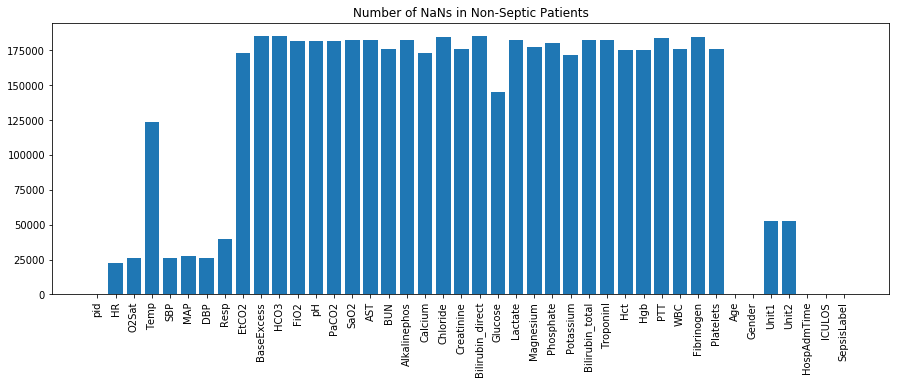

In [119]:
# Across Septic and Non-Septic patients
septic_df = dataset[dataset.SepsisLabel == 1]
nonsep_df = dataset[dataset.SepsisLabel == 0]

sep_na_count = septic_df.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(sep_na_count.index, sep_na_count.values)
plt.title("Number of NaNs in Septic Patients")
plt.xticks(rotation=90)
plt.show()

nonsep_na_count = nonsep_df.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(nonsep_na_count.index, nonsep_na_count.values)
plt.title("Number of NaNs in Non-Septic Patients")
plt.xticks(rotation=90)
plt.show()

### What is the distribution of time steps across septic patients and non-septic patients

In [185]:
pos_time_agg = patient_df.groupby('pid').filter(lambda x: x['SepsisLabel'].any())
neg_time_agg = patient_df.groupby('pid').filter(lambda x: x['SepsisLabel'].sum() == 0)

In [177]:
time_agg.groupby('pid').ICULOS.agg(['count'])['count'].min(), time_agg.groupby('pid').ICULOS.agg(['count'])['count'].max()

(8, 336)

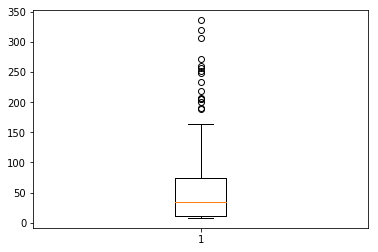

In [179]:
plt.boxplot(time_agg.groupby('pid').ICULOS.agg(['count'])['count'])
plt.show()

In [182]:
time_agg = 
time_agg['count'].min(), time_agg['count'].max()

(15524, 15524)

In [183]:
(time_agg['count'] > 30).sum()

1

{'boxes': [<matplotlib.lines.Line2D at 0x16526a6a0>],
 'caps': [<matplotlib.lines.Line2D at 0x16526ae80>,
 'fliers': [<matplotlib.lines.Line2D at 0x165f1c898>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x165f1c550>],
 'whiskers': [<matplotlib.lines.Line2D at 0x16526a7f0>,
  <matplotlib.lines.Line2D at 0x16526ab38>]}

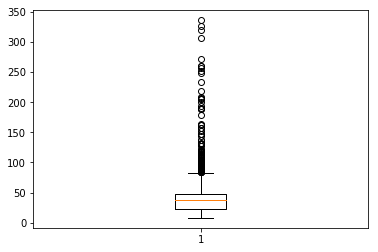

In [154]:
plt.boxplot(time_agg['count'])